# Bin analysis notebook

In this notebook we compute some basic statistics and make some plots to understand how the items differ between the three difficulty bins. We focus only on the source sentences.

In [5]:
%matplotlib inline
from collections import Counter
import os
import sys
import json
import numpy as np
import matplotlib.pyplot as plt

# Work in this notebook's directory (data/)
cd = os.path.abspath(".")
sys.path.append(os.path.abspath(".."))  # import project modules from parent

from data import load_jsonl_pairs
from binning import parse_bins, assign_bin, coerce_esa, quantile_bin_tuples, balance_bins
from main import choose_bins, assign_difficulty_bins
from wordfreq import word_frequency

bar_scatter = 'scatter'
plot = True

c:\Users\Tijsw\anaconda3\envs\dl4nlp\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [6]:
# Load data
items = load_jsonl_pairs(os.path.join(cd, 'wmt24_estimated_normalized.jsonl'))
items_head = items[:10]
print('No. of items:', len(items))
print('First item:', items[0])

No. of items: 3840
First item: {'src_lang': 'en', 'tgt_lang': 'de', 'src': "Siso's depictions of land, water center new gallery exhibition", 'tgt': 'Sisos Darstellungen von Land und Wasser in neuer Ausstellung', 'difficulty_score': 0.8912068449420368, 'meta': {'domain': 'news', 'document_id': 'test-en-news_beverly_press.3585', 'segment_id': 1, 'is_bad_source': False, 'original_target': 'Sisos Darstellungen von Land und Wasser stehen im Mittelpunkt der neuen Galerieausstellung', 'difficulty_score': 0.8912068449420368}}


We work with 4 translation directions, all from english into another language. We  have an equal number of sentences for each:

In [7]:
def count_langs(items):
    pair_counts = Counter()
    for it in items:
        src = it.get('src_lang')
        tgt = it.get('tgt_lang')
        pair_counts[(src, tgt)] += 1
    for (src, tgt), count in pair_counts.items():
        print(f"{src} -> {tgt}: {count}")
    return pair_counts

pair_counts = count_langs(items)

en -> de: 960
en -> es: 960
en -> nl: 960
en -> zh: 960


Note that the difficulty score only depends on the English source sentence. Below we plot the distribution of difficulty scores:

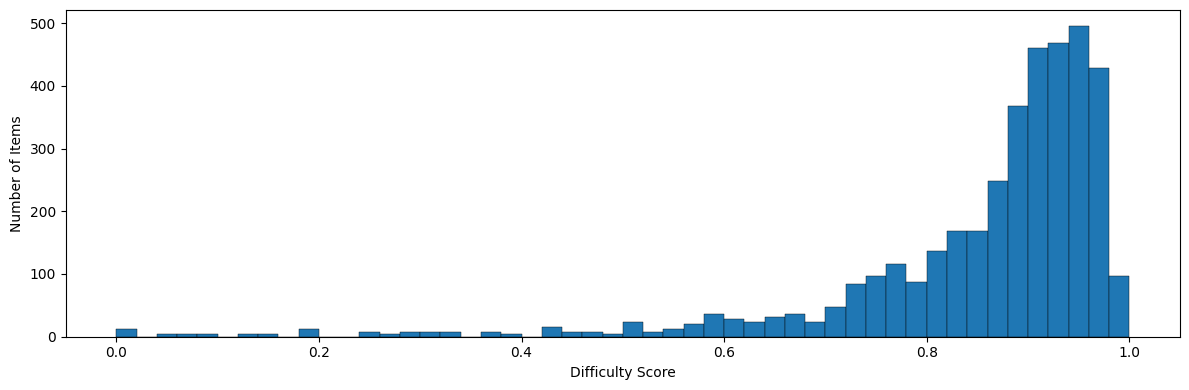

In [50]:
# Plot difficulty score distribution
if plot:
    fig, ax = plt.subplots(figsize=(12, 4))
    scores = [it.get('difficulty_score') for it in items]
    ax.hist(scores, bins=50, edgecolor='black', linewidth=0.3)
    plt.xlabel('Difficulty Score')
    plt.ylabel('Number of Items')
    plt.tight_layout()
    plt.show()

Next we define and assign bin labels. We split the dataset into 3 (almost) equal parts based on difficulty score. Note that lower score means harder to translate, so the the 'Hard' bin is `(-3.64 - 0.027]` and the 'Easy' bin is `(0.317 - 0.62]`.

Note: We allowed for the option to balance the bins when they are not of equal size. Balancing was implemented by randomly pruning the bigger bins till they all reach the same size. Because our dataset has size divisible by 3, we did not need it.

In [49]:
# Create bins and assign difficulty
bin_tuples = choose_bins(items, "quantile_balanced")
assign_difficulty_bins(items, bin_tuples, balanced=True)

# Fixed label strings used in your script
bin1, bin2, bin3 = '(0.0 - 0.861]', '(0.861 - 0.929]', '(0.929 - 1.0]'
bins = [bin1, bin2, bin3]
print(bins)

['(0.0 - 0.861]', '(0.861 - 0.929]', '(0.929 - 1.0]']


To see how the quantile binnig and the balancing relates to the difficulty score distribution, we plot the distribution again only color the bars based on bins.

50
50
50


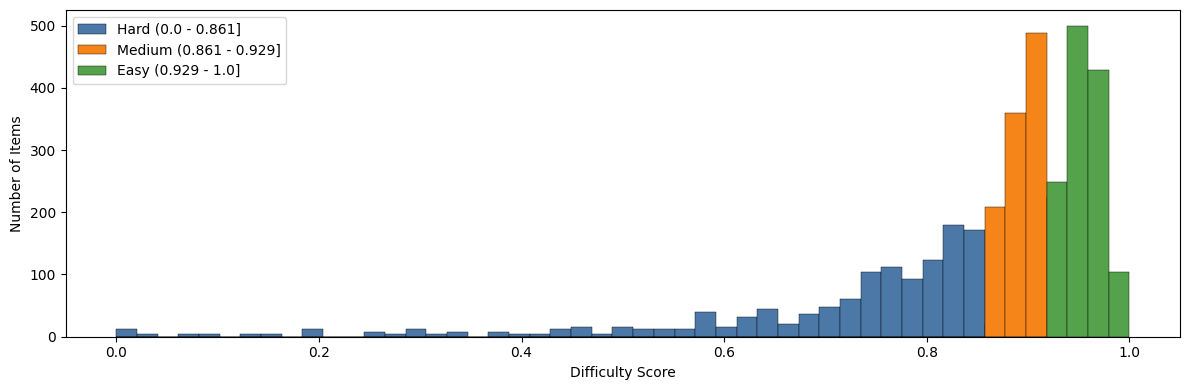

In [ ]:
# Plot difficulty score distribution per bin
if plot:
    fig, ax = plt.subplots(figsize=(12, 4))
    shared_bins = np.linspace(0.0, 1.0, 50) # 50 works well
    colors = ['#4C78A8', '#F58518', '#54A24B']
    labels = {bin1: 'Hard', bin2: 'Medium', bin3: 'Easy'}
    for idx, bin_label in enumerate(bins):
        scores = [it.get('difficulty_score') for it in items if it.get('difficulty') == bin_label]
        ax.hist(scores, bins=shared_bins, color=colors[idx],
            label=f"{labels[bin_label]} {bin_label}", 
            edgecolor='black', linewidth=0.3)
    plt.legend()
    plt.xlabel('Difficulty Score')
    plt.ylabel('Number of Items')
    plt.tight_layout()
    plt.show()

Note: The loss of shape we think is from the balancing, where we randomly prune the larger bins untill they are all of equal size.

Next, we want to grab some statistics and figures to better understand these bins.

We make 3 plots: \
#1. Frequency of certain sentence lenghts in number of words \
#2. Frequency of certain sentence lengths in number of characters \
#3. Rarity score per sentence computed as the mean rarity score over the words

In [5]:
def sentence_count_words(bin_label, items=items):
    return [len(it.get('src').split()) for it in items if it.get('difficulty') == bin_label]

def sentence_count_chars(bin_label, items=items):
    return [len(it.get('src')) for it in items if it.get('difficulty') == bin_label]

def sentence_avg_word_frequency(bin_label, items):
    sentences = [it.get('src').lower().split() for it in items if it.get('difficulty') == bin_label]
    sentence_scores = []
    for sentence in sentences:
        sentence_word_freq = [word_frequency(word, 'en', wordlist='large') for word in sentence]
        sentence_word_scores = [-np.log(f + 1e-9) for f in sentence_word_freq]
        sentence_scores.append(sum(sentence_word_scores) / len(sentence_word_scores))
    return sentence_scores

ZeroDivisionError: division by zero

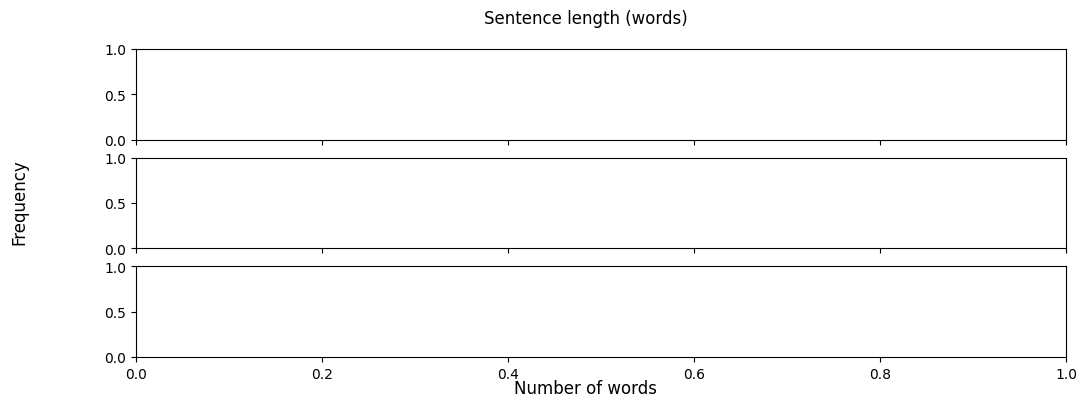

In [6]:
# Plot scatter plot of sentence lengths in words
if plot:
    fig, axes = plt.subplots(3, 1, figsize=(12, 4), sharex=True)
    fig.suptitle('Sentence length (words)')
    fig.supylabel('Frequency')
    fig.supxlabel('Number of words')
    wc_max = 0
    for idx, bin_label in enumerate(bins):
        word_counts = sentence_count_words(bin_label)
        mean = sum(word_counts) / len(word_counts)
        wc = dict(sorted(Counter(word_counts).items()))
        lengths = list(wc.keys())
        counts = list(wc.values())
        wc_max = max(wc_max, max(counts))
        ax = axes[idx]
        if bar_scatter == 'scatter':
            ax.scatter(lengths, counts, color='steelblue', s=1)
        if bar_scatter == 'bar':
            ax.bar(lengths, counts)
        ax.axvline(mean, color="red", linestyle="--", linewidth=1, label=f"mean={mean:.2f}")
        ax.legend()
        ax.set_ylim(0, 150)
    axes[0].set_title(f"{bin1} (Hard)")
    axes[1].set_title(f"{bin2} (Medium)")
    axes[2].set_title(f"{bin3} (Easy)")

    plt.tight_layout()
    plt.show()

    # Plot scatter plot of sentence lengths in characters
if plot:
    fig, axes = plt.subplots(3, 1, figsize=(12, 4), sharex=True)
    fig.suptitle('Sentence length (characters)')
    fig.supylabel('Frequency')
    fig.supxlabel('Number of characters')
    cc_max = 0
    for idx, bin_label in enumerate(bins):
        char_counts = sentence_count_chars(bin_label)
        mean = sum(char_counts) / len(char_counts)
        cc = dict(sorted(Counter(char_counts).items()))
        lengths = list(cc.keys())
        counts = list(cc.values())
        cc_max = max(cc_max, max(counts))
        ax = axes[idx]
        if bar_scatter == 'scatter':
            ax.scatter(lengths, counts, color='steelblue', s=1)
        elif bar_scatter == 'bar':
            ax.bar(lengths, counts)
        ax.axvline(mean, color="red", linestyle="--", linewidth=1, label=f"mean={mean:.2f}")
        ax.legend()
        ax.set_ylim(0, 50)
    
    axes[0].set_title(f"{bin1} (Hard)")
    axes[1].set_title(f"{bin2} (Medium)")
    axes[2].set_title(f"{bin3} (Easy)")

    plt.tight_layout()
    plt.show()

For these first two plots, we expect the easy sentences to most often be short, whereas hard sentences can both be long and short. Our plots reflect this as well.

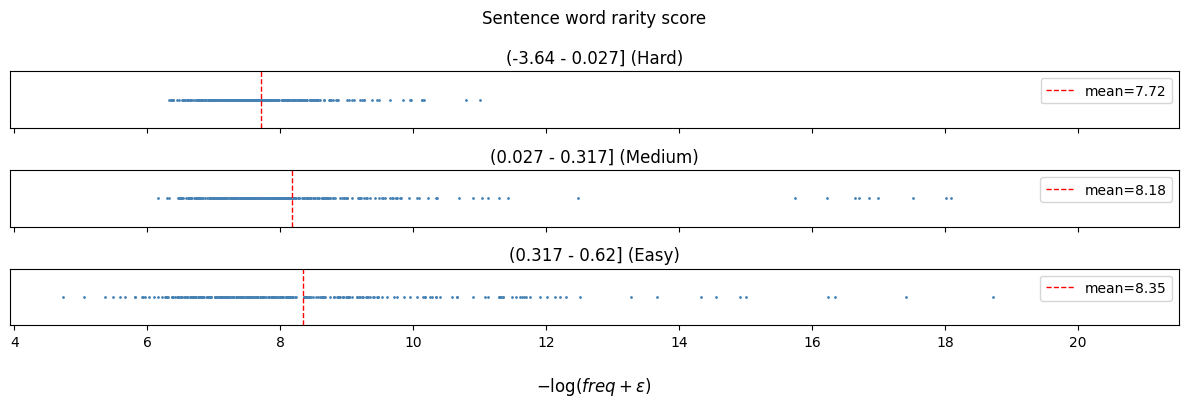

In [ ]:
# Plot sentence word rarity score per bin
fig, axes = plt.subplots(3, 1, figsize=(12, 4), sharex=True)
fig.suptitle('Sentence word rarity score')
fig.supxlabel(r'$-\log(freq + \epsilon)$')
rarity_max = 0
for idx, bin_label in enumerate(bins):
    rarity_scores = sentence_avg_word_frequency(bin_label, items)
    mean = sum(rarity_scores) / len(rarity_scores) if rarity_scores else 0.0
    rarity = dict(sorted(Counter(rarity_scores).items()))
    lengths = list(rarity.keys())
    counts = list(rarity.values())
    if counts:
        rarity_max = max(rarity_max, max(counts))
    ax = axes[idx]
    if bar_scatter == 'scatter':
        ax.scatter(lengths, counts, color='steelblue', s=1)
    elif bar_scatter == 'bar':
        ax.bar(lengths, counts)
    ax.axvline(mean, color="red", linestyle="--", linewidth=1, label=f"mean={mean:.2f}")
    ax.legend()
    ax.yaxis.set_visible(False)
    ax.set_ylim(3, 5)

axes[0].set_title(f"{bin1} (Hard)")
axes[1].set_title(f"{bin2} (Medium)")
axes[2].set_title(f"{bin3} (Easy)")

plt.tight_layout()
plt.show()

*As the rarity scores are foats, the frequency is alwas 1, so there is no need for a y-axis

For this third plot, we see the 'Easy' bin has the higher rarity scores, so these use on average more rare words. This is likely due to special cases such as emojis and urls which are easy to translate (change nothing) but do not occur in the `wordfreq` library.

Next, we look qualitatively at some of the hardest and easiest sentences to translate and their Dutch translations. Most (4/5) authors speak Dutch so we can try to understand what makes translation difficult.

In [ ]:
def find_hardest_sentences(items, n=5, target_language='nl'):
    hard_items = [it for it in items if it.get('difficulty') == bin1 and it.get('tgt_lang') == target_language]
    hard_items_sorted = sorted(hard_items, key=lambda x: x.get('difficulty_score'), reverse=False)
    top_n_hardest = hard_items_sorted[:n]
    print(f'Top {n} hardest sentences:')
    for it in top_n_hardest:
         print('difficulty score:', it.get('difficulty_score'))
         print("en:         ", it.get('src'))
         print("nl:         ", it.get('tgt'))
         print("original nl:", it.get('meta').get('original_target'))
         print('\n')

def find_easiest_sentences(items, n=5, target_language='nl'):
    easy_items = [it for it in items if it.get('difficulty') == bin3 and it.get('tgt_lang') == target_language]
    easy_items_sorted = sorted(easy_items, key=lambda x: x.get('difficulty_score'), reverse=True)
    top_n_easiest = easy_items_sorted[:n]
    print(f'Top {n} easiest sentences:')
    for it in top_n_easiest:
         print('difficulty score:', it.get('difficulty_score'))
         print("en:         ", it.get('src'))
         print("nl:         ", it.get('tgt'))
         print("original nl:", it.get('meta').get('original_target'))
         print('\n')

find_hardest_sentences(items, n=5, target_language='nl')
find_easiest_sentences(items, n=5, target_language='nl')

Top 5 hardest sentences:
difficulty score: -3.640363931655884
en:          To create the antique brass ornament, I just went in with a coat of rub and buff onto the entire ornament there. And then of course, we have to get that antique look with the alcohol ink. So I went in with ginger first. I applied a droplet onto our ornament and just blended it out like so. And I just continued that process until I had as many layers as I liked, and it looked really antiqued in like an actual metal ornament. After that, I did go in with a little bit more of that burnished amber spray paint as well, and just applied that to the surface, to kind of give it that oxidized look like we did for the bell ornaments. And that is how I finished off these antique brass bobbles. Really simple and easy, but honestly, they look like real metal and they're beautiful.
nl:          Om het antieke koperen ornament te maken, ben ik gewoon aan de slag gegaan met wat glansmiddel en heb ik het hele ornament opgepoetst

The easiest sentences are all very short, consisting of learned phrases (e.g. wait and see -> even aankijken) and strong alignment (e.g. Good news everyone -> Goed nieuws allemaal).

The harder sentences are mostly long (>80 words). Also most of these sentences are multiple sentences and/or contain many subsentences.

Another interesting idea is to look at what makes short sentences difficult. We can do this by sorting the 'Hard' bin based on word length. Again we restrict to Dutch

In [ ]:
target_language = 'nl'
hard_items = [it for it in items if it.get('difficulty') == bin1 and it.get('tgt_lang') == target_language]
hard_items_by_length = sorted(hard_items, key=lambda it: len(it.get('src', '').split()))
top_n_shortest_hard = hard_items_by_length[:5]
for it in top_n_shortest_hard:
     print('difficulty score:', it.get('difficulty_score'))
     print('length:', len(it.get('src', '').split()), 'words')
     print("en:         ", it.get('src'))
     print("nl:         ", it.get('tgt'))
     print("original nl:", it.get('meta').get('original_target'))
     print('\n')


difficulty score: -0.035575222223997116
length: 4 words
en:          Fisheye is way overkill.
nl:          De visooglens is echt overdreven.
original nl: De visooglens is echt te veel van het goede.


difficulty score: -0.08980444073677063
length: 5 words
en:          when in on $big 4.25-.35
nl:          als ik koop voor $big 4,25-,35
original nl: Als je meedoet aan BIG op 4,25-4,35


difficulty score: -0.030399732291698456
length: 6 words
en:          switch to cash, no more margin.
nl:          Overschakelen op cash en geen marges meer.
original nl: Overschakelen op cash en geen marges meer.


difficulty score: -0.21846111118793488
length: 6 words
en:          @user26 cheeked up. I love HER*
nl:          @user26 was respectloos. Ik ben gek op HAAR*
original nl: @user26 deed onbeschoft. Ik ben gek op HAAR*


difficulty score: -0.13138271868228912
length: 8 words
en:          @user48 Bootstrap would be sweet relief over tailwind
nl:          @user48 Bootstrap zou heel wat beter zijn d

In these examples, we find words are used that aren't really words (e.g. @user26), and very obscure words/phrases (e.g. cheeked up), and words without a translation (e.g. Bootstrap).